In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [51]:
from collections import defaultdict, Counter
from itertools import product
from functools import wraps
import json
import re
import os
from os.path import isdir, join
import shutil
from scipy import optimize

In [3]:
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
from joblib import delayed, Parallel
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib_pretty_tex as pgf

In [4]:
import utils
sns.set_context('paper', font_scale=1.4, rc={'legend.frameon': True})

In [12]:
import importlib
importlib.reload(utils)

<module 'utils' from '/pc2014-data3/cburr/hybrid-distortions/notebooks/utils.py'>

In [5]:
scenarios = ['tip_x=0um_y=-1000um_alternate', 'tip_x=0um_y=-1000um', 'Nominal', 'tip_x=0um_y=+1000um', 'tip_x=0um_y=+1000um_alternate']

out_dir = f'output/{"_".join(scenarios)}/further_studies/'
if isdir(out_dir):
    shutil.rmtree(out_dir)
os.makedirs(out_dir)

clusters, tracks, residuals, particles = utils.load(scenarios, fast=False)

In [6]:
sigma = {
    0.5: 0.382924922548026,
    1: 0.682689492137086,
    2: 0.954499736103642,
    3: 0.997300203936740
}
sns.set_palette(sns.color_palette('colorblind', len(scenarios)))
sns.set_style('whitegrid')

In [7]:
particles.scenario.cat.categories

Index(['tip_x=0um_y=-1000um_alternate', 'tip_x=0um_y=-1000um', 'Nominal',
       'tip_x=0um_y=+1000um', 'tip_x=0um_y=+1000um_alternate'],
      dtype='object')

## Impact parameter

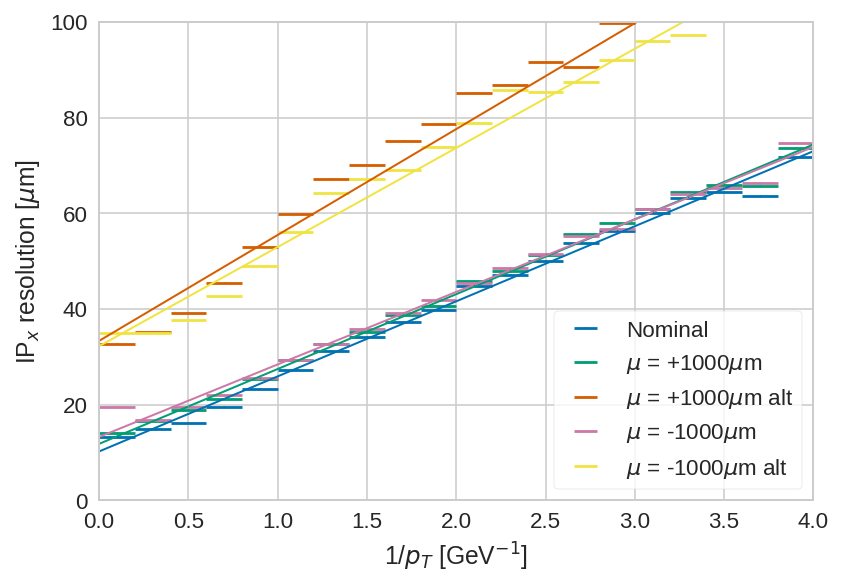

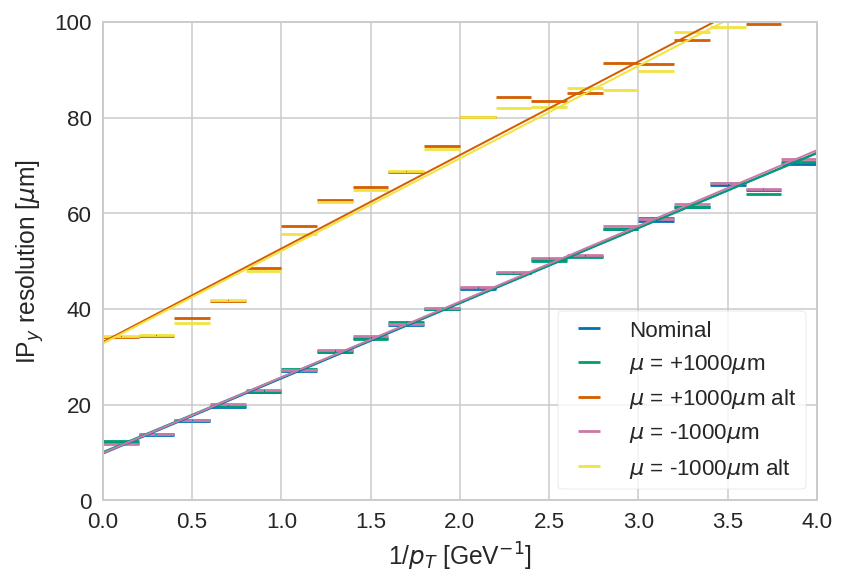

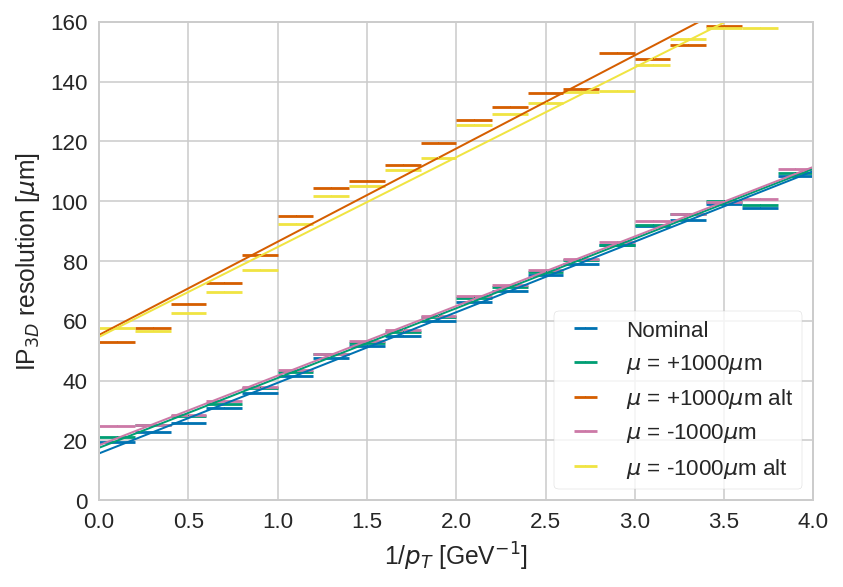

In [13]:
def plot_ip(grouped, ylabel, fn_suffix):
    plt.figure()
    for scenario in grouped.index.levels[0]:
        x, y = zip(*grouped[scenario].items())
        x = [list(map(float, _x[1:-1].split(', '))) for _x in x]
        xs = np.array(list(map(np.mean, x)))
        l = plt.errorbar(xs, y, xerr=np.diff(x, axis=1)/2, label=utils.format_label(scenario), fmt=',')
        a, b = np.polyfit(xs, y, 1)
        plt.plot(bins, a*bins + b, ls='-', c=l[0].get_color(), lw=1)
    plt.xlim(bins[0], bins[-1])
    plt.xlabel('1/$p_T$ [GeV$^{-1}$]')
    plt.ylim(0, [100, 160][ylabel == 'IP$_{3D}$'])
    plt.ylabel(f'{ylabel} resolution [$\\mu$m]')
    plt.legend(loc='best', frameon=True)
    pgf.savefig(join(out_dir, f'residual_{fn_suffix}.pgf.png'))

bins = np.linspace(0, 4, 21)
_tracks = tracks.query('true_pz == true_pz & (true_pz > 0)').copy()
_tracks.eval('true_pt = sqrt(true_px**2 + true_py**2)', inplace=True)
_tracks.eval('true_p = sqrt(true_px**2 + true_py**2 + true_pz**2)', inplace=True)
_tracks.eval('true_eta = arctanh(true_pz/true_p)', inplace=True)
_tracks = _tracks.query('(2 < true_eta) & (true_eta < 5) & (true_pt > 200)').copy()
_tracks.eval('true_inv_pt_gev = 1000/true_pt', inplace=True)
grouped = _tracks.groupby(['scenario', pd.cut(_tracks.true_inv_pt_gev, bins)])
plot_ip(grouped.apply(lambda x: x.eval('abs(IPx*1000)').quantile()), 'IP$_x$', 'IPx')
plot_ip(grouped.apply(lambda x: x.eval('abs(IPy*1000)').quantile()), 'IP$_y$', 'IPy')
plot_ip(grouped.apply(lambda x: x.eval('abs(IP3D*1000)').quantile()), 'IP$_{3D}$', 'IP3D')

## $x/y/z$ residuals

Here the residual is plotted between:
 - The cluster position in the true geometry
 - The point of closest approach for the track reconstuced in the misaligned geometry

As you might expect this only (appreciably) affects the residual in $x$ for rotations around $y$

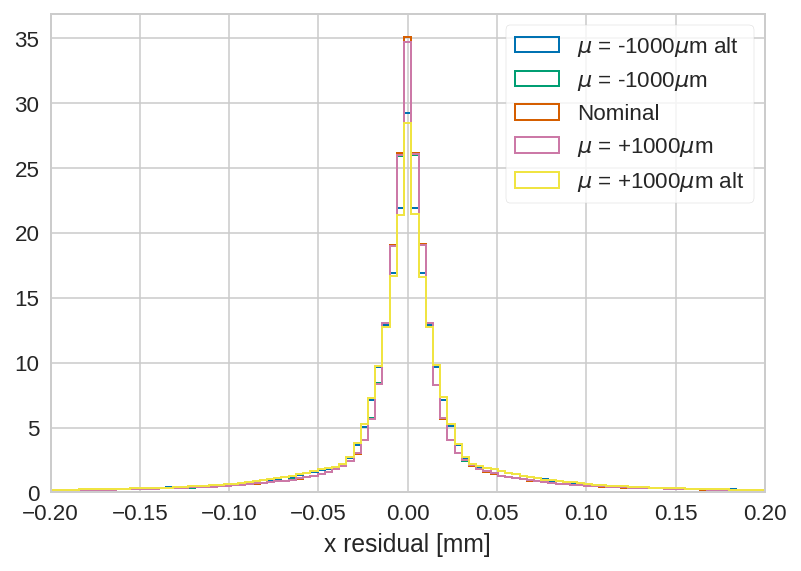

In [16]:
bins = np.linspace(-0.2, 0.2, 100)
for scenario in scenarios:
    residuals[scenario].residual_x.hist(
        bins=bins, histtype='step', lw=1, normed=True, label=utils.format_label(scenario))
plt.legend(loc='best', frameon=True)
plt.xlabel('x residual [mm]')
plt.xlim((bins[0], bins[-1]))
pgf.savefig(join(out_dir, 'residual_x_integrated.pgf.png'))

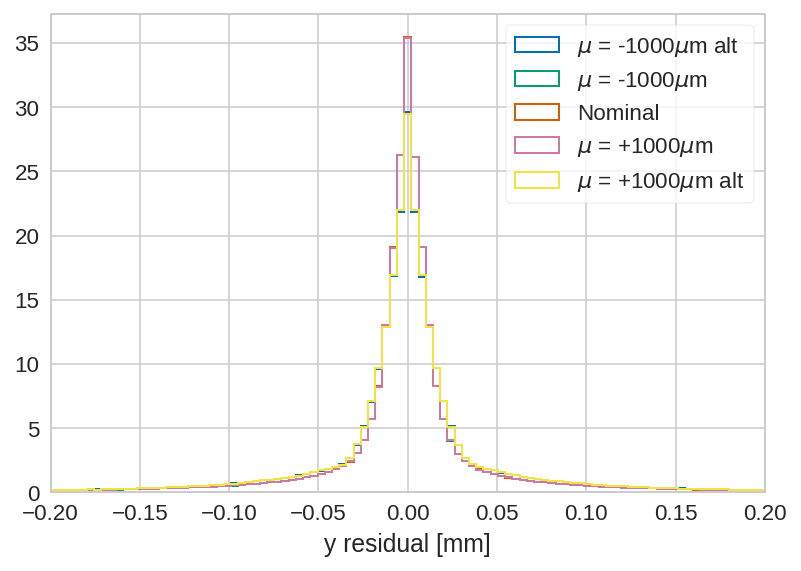

In [17]:
bins = np.linspace(-0.2, 0.2, 100)
for scenario in scenarios:
    residuals[scenario].residual_y.hist(
        bins=bins, histtype='step', lw=1, normed=True, label=utils.format_label(scenario))
plt.legend(loc='best', frameon=True)
plt.xlabel('y residual [mm]')
plt.xlim((bins[0], bins[-1]))
pgf.savefig(join(out_dir, 'residual_y_integrated.pgf.png'))

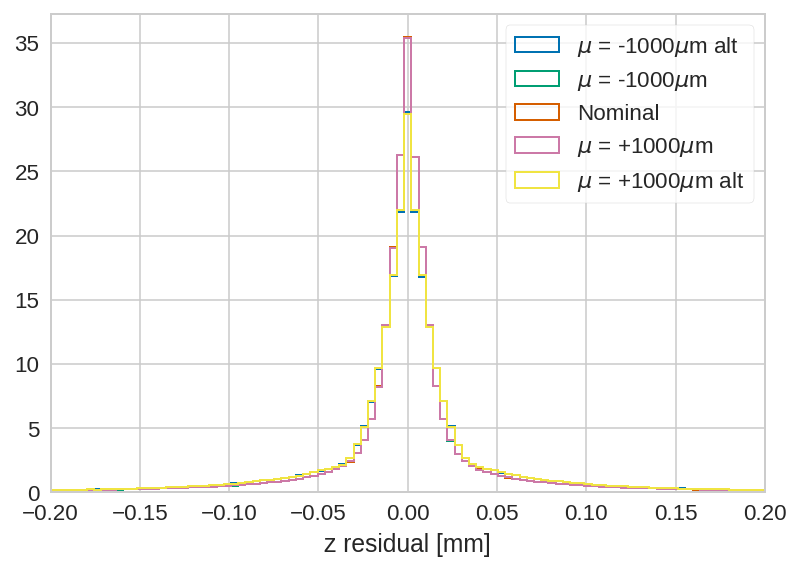

In [18]:
bins = np.linspace(-0.2, 0.2, 100)
for scenario in scenarios:
    residuals[scenario].residual_y.hist(
        bins=bins, histtype='step', lw=1, normed=True, label=utils.format_label(scenario))
plt.legend(loc='best', frameon=True)
plt.xlabel('z residual [mm]')
plt.xlim((bins[0], bins[-1]))
pgf.savefig(join(out_dir, 'residual_z_integrated.pgf.png'))

## $x/y/z$ residuals as a function of VP station

Here I plot the $x/y/z$ residuals (above) as a function of VP station. The coutour lines corrosponding to the median, $\pm1\sigma$ and $\pm2\sigma$ are shown, where the values are obtained by taking the percentiles of the residual distribution.

I also plot the true residual, which is the residual between the true cluster location (using nominal geometry) and the track.

In [19]:
station_positions = {
    0: -281.25, 1: -256.25, 2: -231.25, 3: -206.25, 4: -131.25, 5: -56.25, 6: -31.25,
    7: -6.25, 8: 18.75, 9: 43.75, 10: 68.75, 11: 93.75, 12: 118.75, 13: 143.75,
    14: 168.75, 15: 193.75, 16: 218.75, 17: 243.75, 18: 268.75, 19: 318.75,
    20: 393.75, 21: 493.75, 22: 593.75, 23: 643.75, 24: 693.75, 25: 743.75
}

In [20]:
def _get_ys(scenario, var, side):
    _var = var[[0, len('true_')][scenario == 'Nominal' and var.startswith('true_')]:]
    rs = residuals[scenario]
    if side is not None:
        rs = rs.query(f'module % 2 == {side}')
    rs = rs.groupby('station', sort=True)[_var]
    ys = rs.quantile([0.5+sigma[2]/2, 0.5+sigma[1]/2, 0.5, 0.5-sigma[1]/2, 0.5-sigma[2]/2])
    return (scenario, side), ys

def plot_residual(var, vs_station=False, sides=None, suffix=''):
    plt.figure()
    sides = sides or list(zip(scenarios, [None]*len(scenarios)))
    stations = residuals['Nominal'].station.cat.categories.values
    alphas = [0.25, 0.75, 1, 0.75, 0.25]
    linestyles = [':', '--', '-', '--', ':']

    xs = [[station_positions[x] for x in stations], stations][vs_station]
    ys = dict(Parallel(n_jobs=len(scenarios), backend='threading')(
        delayed(_get_ys)(scenario, var, side=side) for scenario, side in sides
    ))

    for (scenario, side), colour in zip(sides, sns.color_palette(n_colors=len(scenarios)*len(sides))):
        lines = []
        for (quantile, y), a, ls in zip(ys[(scenario, side)].groupby(level=1, sort=True), alphas, linestyles):
            label = utils.format_label(scenario)
            label = [None, label if side is None else f'{label} - {["even", "odd"][side]}'][quantile == 0.5]
            l, = plt.plot(xs, y.values, c=colour, alpha=a, ls=ls, label=label)
            lines.append(l)

        if scenario == 'Nominal':
            sigma_legend = plt.legend(lines[:3], ['$\pm2\sigma$', '$\pm1\sigma$', 'median'], loc='lower left', frameon=True)

    plt.legend(loc='best', frameon=True)
    plt.gca().add_artist(sigma_legend)
    plt.xlim((0, 25) if vs_station else (station_positions[0], station_positions[25]))
    plt.xlabel('z [mm]')
    plt.ylabel(f'{var.split("_")[-1]} {" ".join(var.split("_")[:-1])} [mm]')
    ylim = max(map(abs, plt.ylim()))
    if var.endswith('_z'):
        ylim *= 1.5
    plt.ylim((-ylim, ylim))
    pgf.savefig(join(out_dir, f'{var}_vs_z{suffix}.pgf.png'))

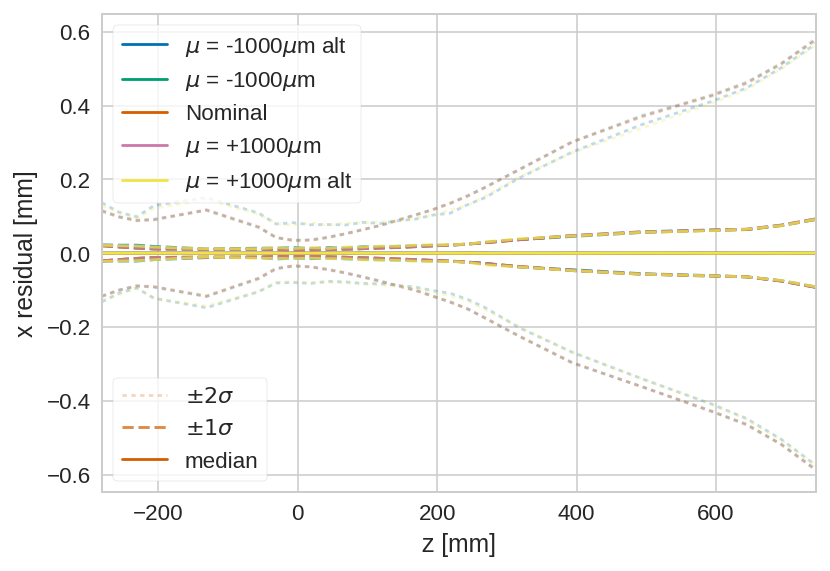

In [21]:
plot_residual('residual_x')

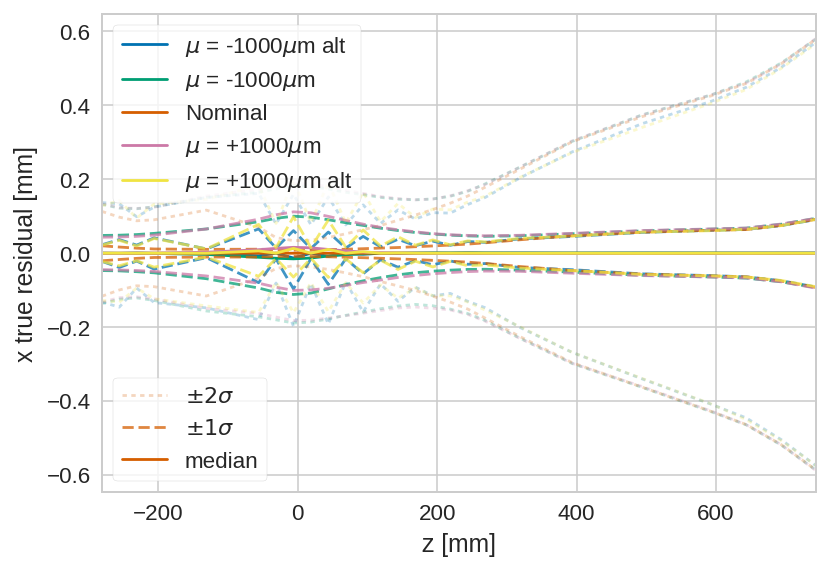

In [22]:
plot_residual('true_residual_x')

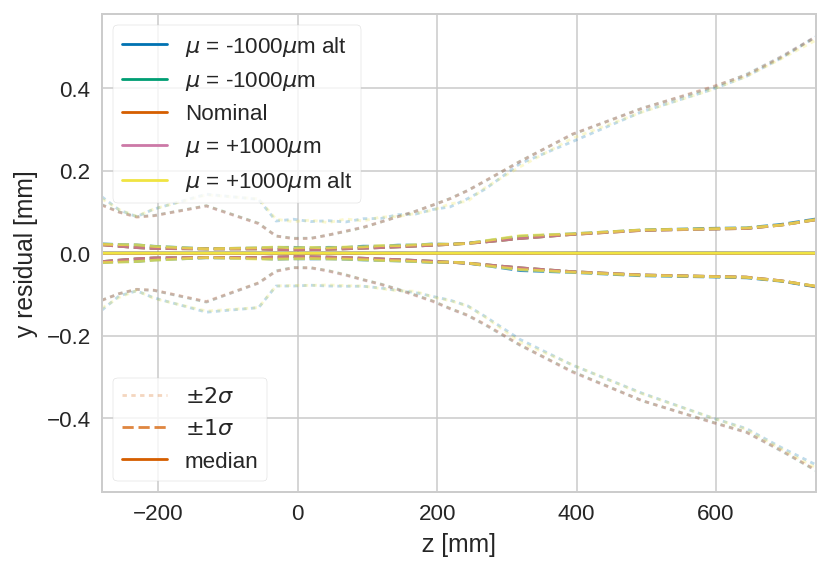

In [23]:
plot_residual('residual_y')

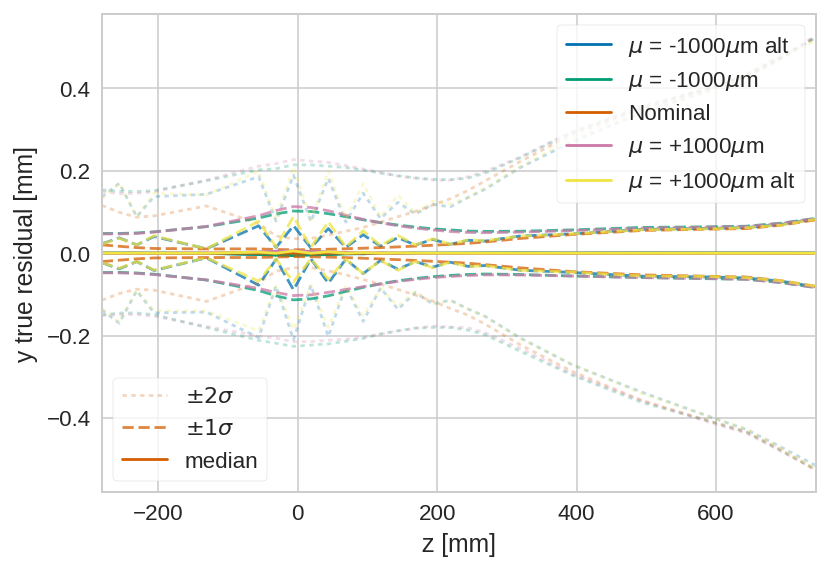

In [24]:
plot_residual('true_residual_y')

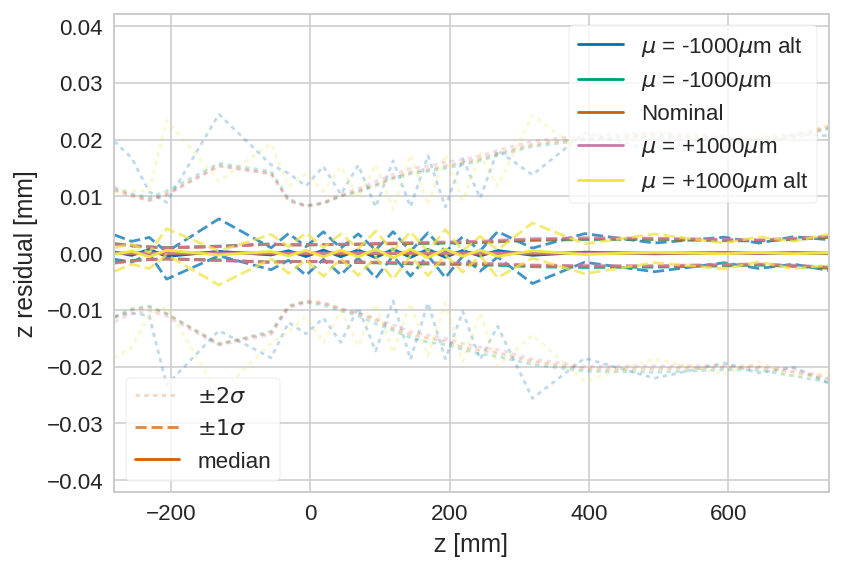

In [25]:
plot_residual('residual_z')

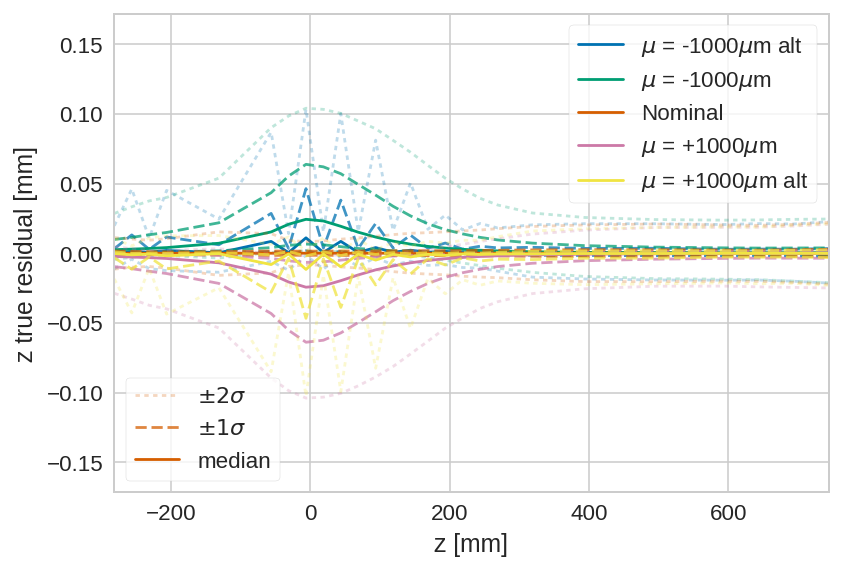

In [26]:
plot_residual('true_residual_z')

### And try splitting tracks by side

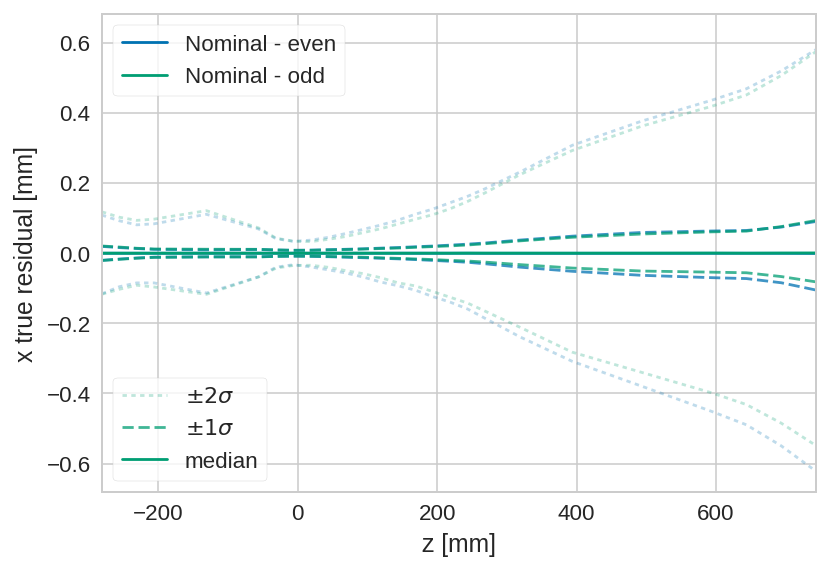

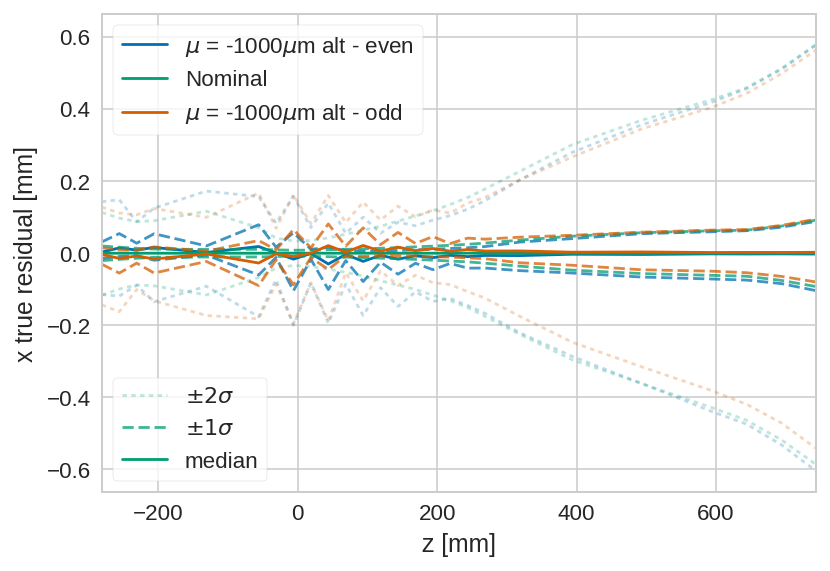

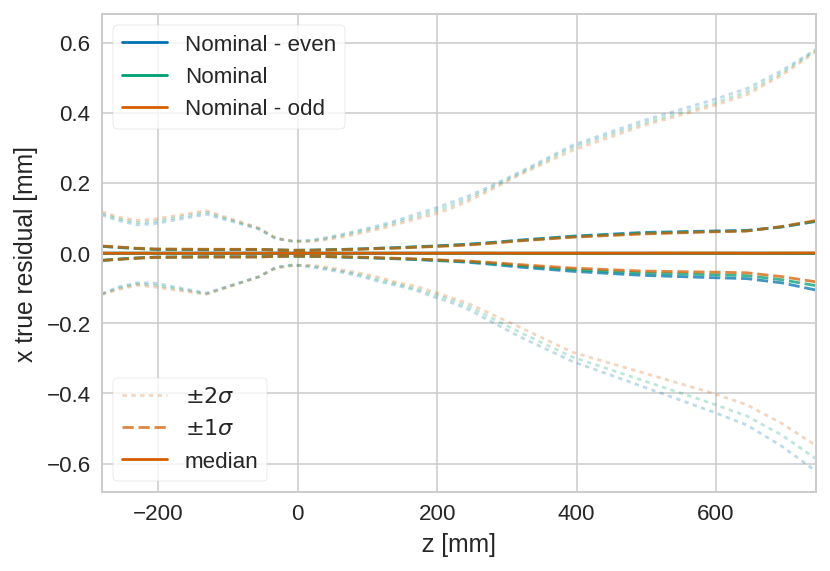

In [27]:
plot_residual('true_residual_x', sides=[('Nominal', 0), ('Nominal', 1)], suffix='_left_right_Original_DB')
plot_residual('true_residual_x', sides=[(scenarios[0], 0), ('Nominal', None), (scenarios[0], 1)], suffix=f'_left_right_{scenarios[0]}')
plot_residual('true_residual_x', sides=[(scenarios[2], 0), ('Nominal', None), (scenarios[2], 1)], suffix=f'_left_right_{scenarios[2]}')

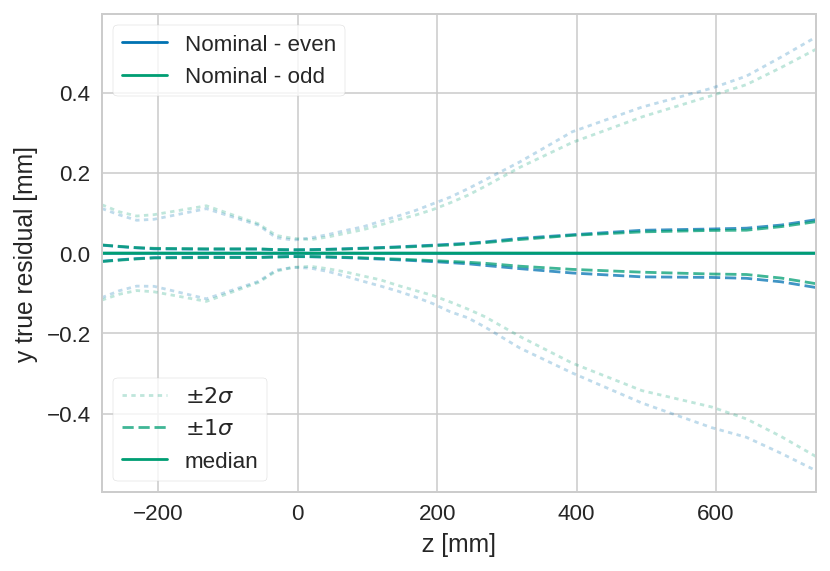

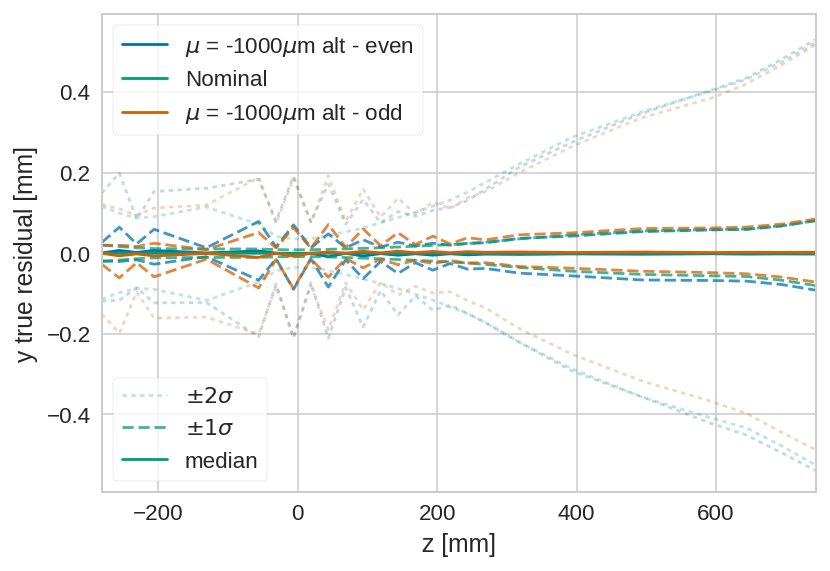

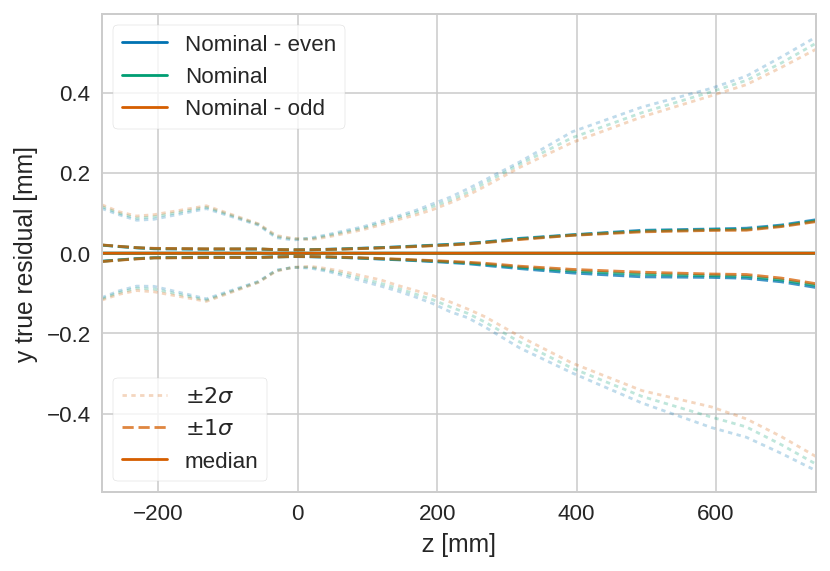

In [28]:
plot_residual('true_residual_y', sides=[('Nominal', 0), ('Nominal', 1)], suffix='_left_right_Original_DB')
plot_residual('true_residual_y', sides=[(scenarios[0], 0), ('Nominal', None), (scenarios[0], 1)], suffix=f'_left_right_{scenarios[0]}')
plot_residual('true_residual_y', sides=[(scenarios[2], 0), ('Nominal', None), (scenarios[2], 1)], suffix=f'_left_right_{scenarios[2]}')

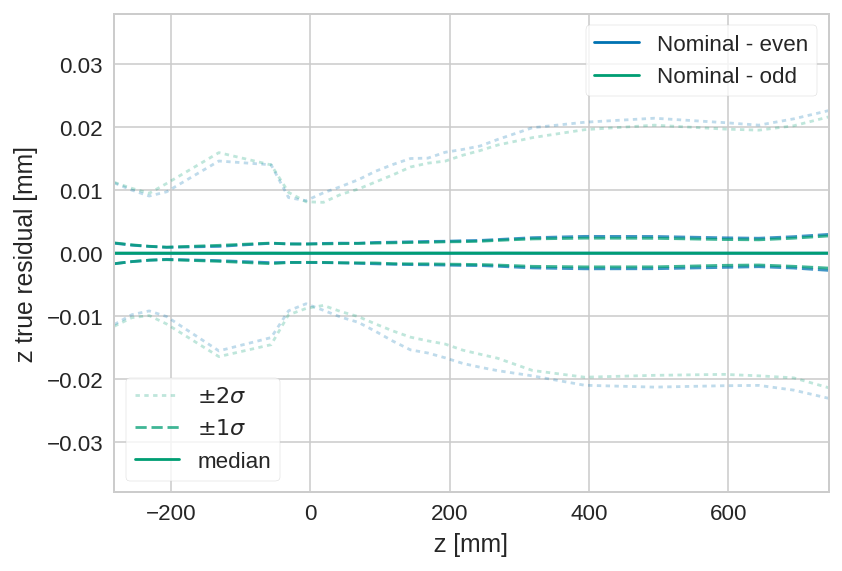

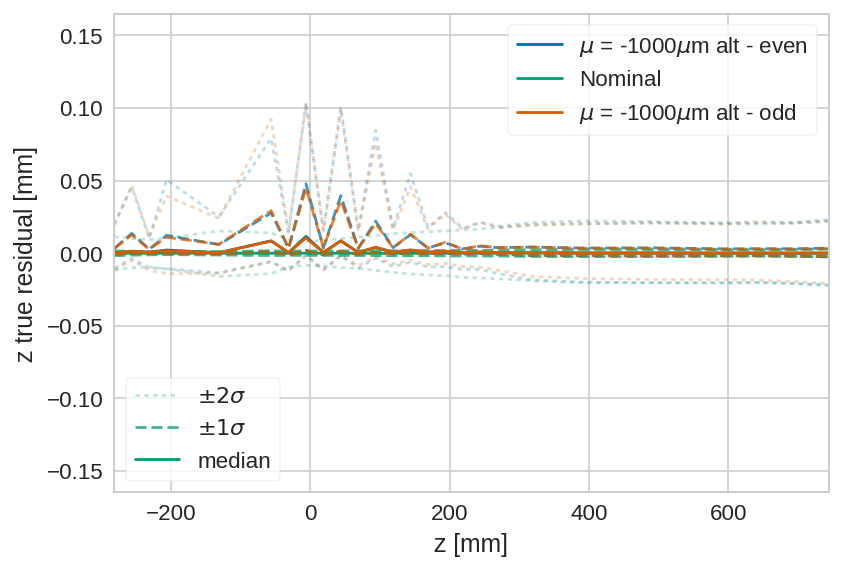

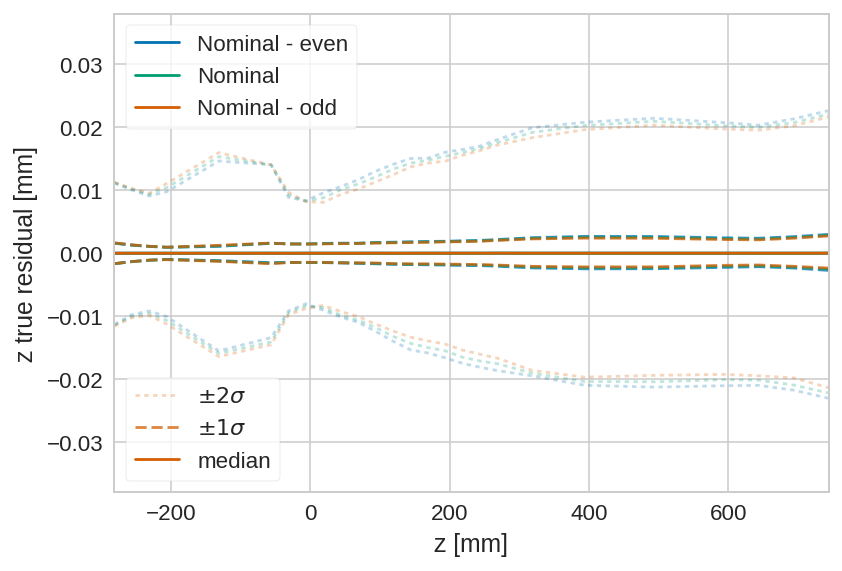

In [29]:
plot_residual('true_residual_z', sides=[('Nominal', 0), ('Nominal', 1)], suffix='_left_right_Original_DB')
plot_residual('true_residual_z', sides=[(scenarios[0], 0), ('Nominal', None), (scenarios[0], 1)], suffix=f'_left_right_{scenarios[0]}')
plot_residual('true_residual_z', sides=[(scenarios[2], 0), ('Nominal', None), (scenarios[2], 1)], suffix=f'_left_right_{scenarios[2]}')

## Momentum resolution of all long tracks

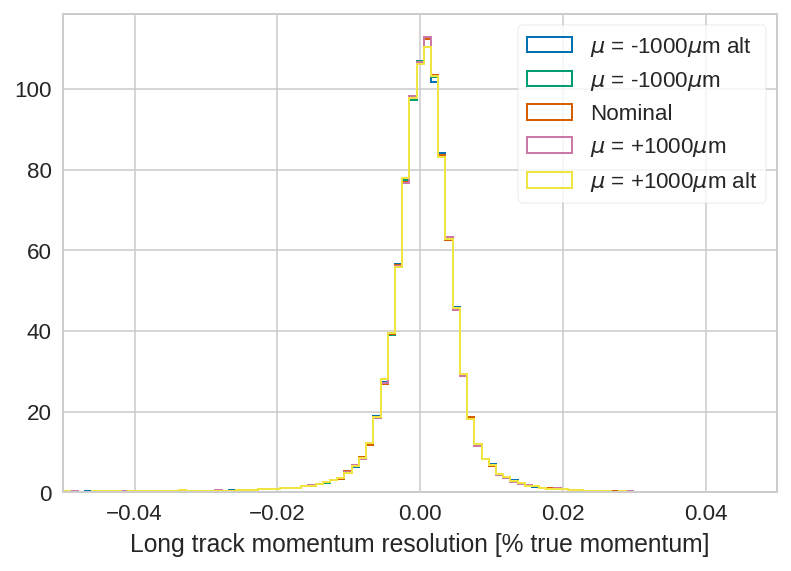

In [30]:
for scenario in scenarios:
    long_tracks = tracks.query(f'(scenario == "{scenario}") & (track_type == "Long")')
    resolution = long_tracks.eval('(p-true_p)/true_p').dropna()
    resolution.hist(bins=np.linspace(-0.05, 0.05, 100), histtype='step', lw=1,
                    label=utils.format_label(scenario), normed=True)
plt.legend(loc='best', frameon=True)
plt.xlim((-0.05, 0.05))
plt.xlabel('Long track momentum resolution [% true momentum]')
pgf.savefig(join(out_dir, 'momentum_resolution_integrated.pgf.png'))

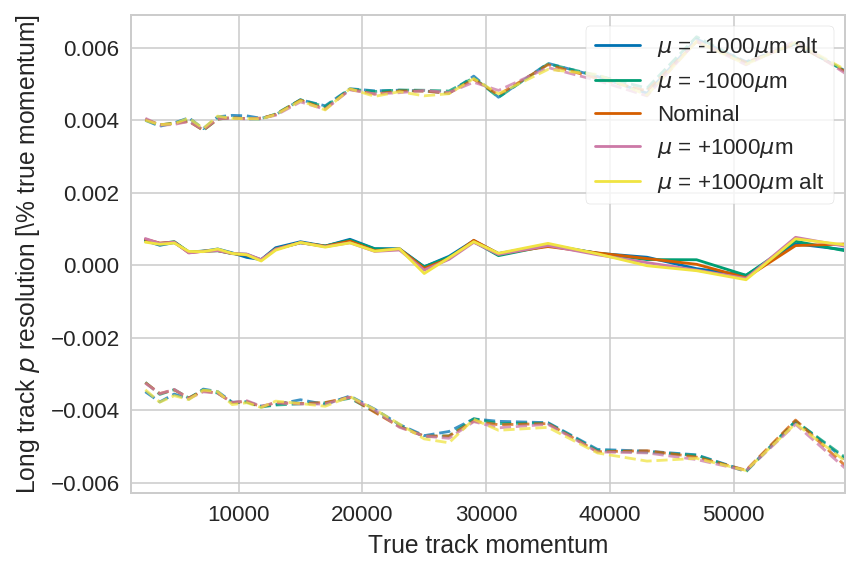

In [31]:
for scenario, colour in zip(scenarios, sns.color_palette(n_colors=len(scenarios))):
    long_tracks = tracks.query(f'(scenario == "{scenario}") & (track_type == "Long")')
    # Use a variable binning to avoid issues with low stats
    xs = np.concatenate([
        np.linspace(1300, 13000, 11),
        np.arange(15000, 31001, 2000),
        np.arange(35000, 61000, 4000)
    ])
    ys = []
    for p_low, p_high in utils.pairwise(xs):
        resolution = long_tracks.query(f'({p_low} <= true_p) & (true_p < {p_high})')
        resolution = resolution.eval('(p-true_p)/true_p').dropna()
        if len(resolution) < 50:
            print(p_low, scenario, len(resolution))
        ys.append([
            resolution.quantile(0.5+sigma[1]/2),
            resolution.median(),
            resolution.quantile(0.5-sigma[1]/2)
        ])

    for y, alpha, ls in zip(zip(*ys), [0.75, 1, 0.75], ['--', '-', '--']):
        plt.plot(xs[:-1]+np.diff(xs), y, c=colour, alpha=alpha, ls=ls,
                 label=(utils.format_label(scenario) if alpha == 1 else None))

plt.legend(loc='best', frameon=True)
plt.xlim((xs[0], xs[-1]))
plt.xlabel('True track momentum')
plt.ylabel('Long track $p$ resolution [\% true momentum]')
pgf.savefig(join(out_dir, 'momentum_resolution_vs_momentum.pgf.png'))

## Ensure we use the same $D^0$ candidates

In [53]:
# Backup the particles dataframe
try:
    particles_backup
except NameError:
    particles_backup = particles
# Remove clones
particles = particles_backup.drop_duplicates(['scenario', 'run_number', 'event_number', 'D0_true_p'], keep='first')
# Only use D0s that exist in all scenarios
counts = Counter(particles.D0_true_p)
particles = particles[[counts[D0_p] == len(scenarios) for D0_p in particles.D0_true_p]]

## $D^0$ vertex fit quality

Here $D^{*+} \rightarrow \left(D^0 \rightarrow K^+ K^- \right) \pi^+$ candidates are reconstructed by:
 - Truth matching tracks (created with NoPIDsParticleMaker) to ensure that all hits on a final state track are assoiated with the same MCParticle
 - The mother of both kaons is then required to be the same MCParticle
 - The mother of the pion must be the same as the mother of the mother of the kaons

The vertex is then fitted using `LoKi::VertexFitter` to build a $D^0$

TODO:
 - Do I need to worry if the mother of the kaon MCParticles is something other than a $D^0$ (so $D^0 \rightarrow X
\rightarrow K^+ K^-)$?
 - Likewise for the $D^{*+}$?

46 (15.3%) events clipped for tip_x=0um_y=-1000um_alternate
   0.5σ = 0.182
   1σ   = 0.457
   2σ   = 1.111
31 (10.3%) events clipped for tip_x=0um_y=-1000um
   0.5σ = 0.139
   1σ   = 0.331
   2σ   = 0.633
29 (9.6%) events clipped for Nominal
   0.5σ = 0.102
   1σ   = 0.323
   2σ   = 0.678
29 (9.6%) events clipped for tip_x=0um_y=+1000um
   0.5σ = 0.091
   1σ   = 0.347
   2σ   = 0.706
59 (19.6%) events clipped for tip_x=0um_y=+1000um_alternate
   0.5σ = 0.129
   1σ   = 0.482
   2σ   = 0.920


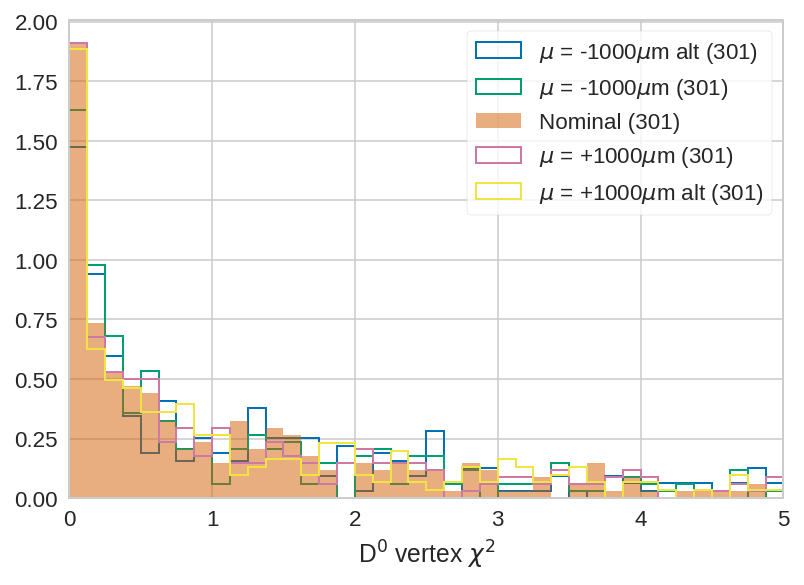

In [54]:
for scenario in scenarios:
    chi2 = particles.query(f'scenario == "{scenario}"').vertex_chi2
    label = f'{utils.format_label(scenario)} ({len(chi2)})'
    if scenario == 'Nominal':
        chi2.hist(bins=np.linspace(0, 5, 41), label=label, alpha=0.5, normed=True)
    else:
        chi2.hist(bins=np.linspace(0, 5, 41), label=label, normed=True, histtype='step', lw=1)
    print(f'{sum(chi2 > 5)} ({sum(chi2 > 5)/len(chi2):.1%}) events clipped for {scenario}')
    # Print sigma values for if this was one side of a normal distribution
    print(f'   0.5σ = {chi2.quantile(sigma[0.5]/2):.3f}')
    print(f'   1σ   = {chi2.quantile(sigma[1]/2):.3f}')
    print(f'   2σ   = {chi2.quantile(sigma[2]/2):.3f}')
plt.legend(loc='best', frameon=True)
plt.xlim((0, 5))
plt.xlabel('D$^0$ vertex $\chi^2$')
pgf.savefig(join(out_dir, 'D0_vertex_chi2.pgf.png'))

## Flight distance resolution

The flight distance is taken to be the distance between the reconstructed $D^0$ vertex (above) and the true $D^{*+}$ origin vertex. I **do not** consider if the $D^{*+}$ is promptly produced.

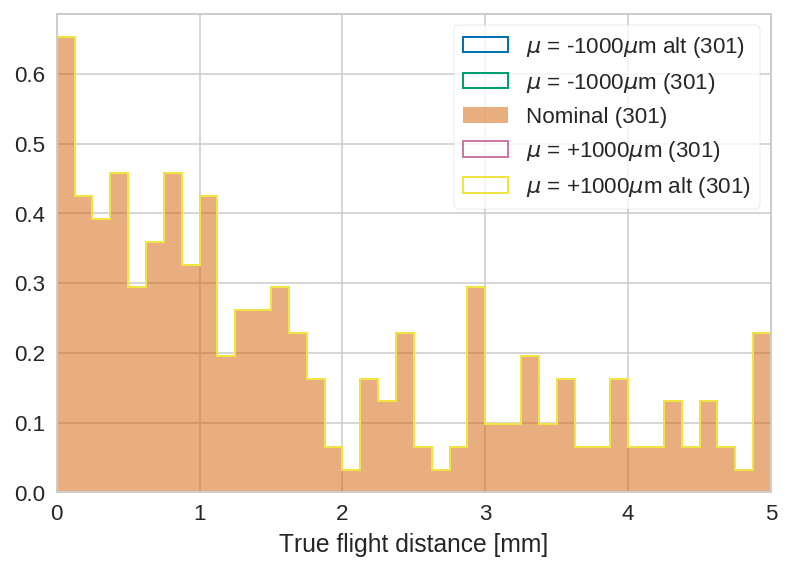

In [55]:
for scenario in scenarios:
    true_fd = particles.query(f'(scenario == "{scenario}")').true_fd
    label = f'{utils.format_label(scenario)} ({len(true_fd)})'
    if scenario == 'Nominal':
        true_fd.hist(bins=np.linspace(0, 5, 41), label=label, alpha=0.5, normed=True)
    else:
        true_fd.hist(bins=np.linspace(0, 5, 41), label=label, normed=True, histtype='step', lw=1)
plt.legend(loc='best', frameon=True)
plt.xlim((0, 5))
plt.xlabel('True flight distance [mm]')
pgf.savefig(join(out_dir, 'true_flight_distance.pgf.png'))

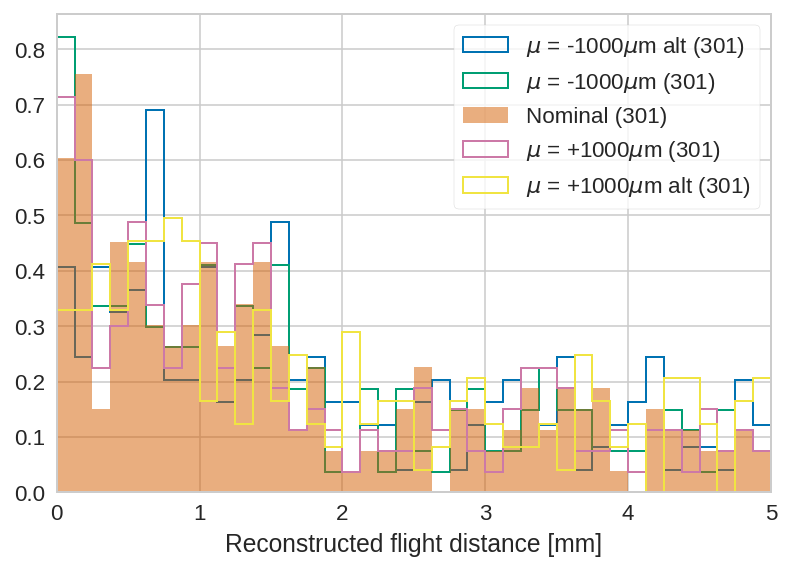

In [56]:
for scenario in scenarios:
    reco_fd = particles.query(f'(scenario == "{scenario}")').fd
    label = f'{utils.format_label(scenario)} ({len(reco_fd)})'
    if scenario == 'Nominal':
        reco_fd.hist(bins=np.linspace(0, 5, 41), label=label, alpha=0.5, normed=True)
    else:
        reco_fd.hist(bins=np.linspace(0, 5, 41), label=label, normed=True, histtype='step', lw=1)
plt.legend(loc='best', frameon=True)
plt.xlim((0, 5))
plt.xlabel('Reconstructed flight distance [mm]')
pgf.savefig(join(out_dir, 'reconstructed_flight_distance.pgf.png'))

tip_x=0um_y=-1000um_alternate 32
  median = -0.308
    0.5σ = 1.259
      1σ = 4.133
tip_x=0um_y=-1000um 18
  median = -0.045
    0.5σ = 0.505
      1σ = 1.698
Nominal 16
  median = -0.068
    0.5σ = 0.474
      1σ = 1.534
tip_x=0um_y=+1000um 18
  median = -0.066
    0.5σ = 0.495
      1σ = 1.676
tip_x=0um_y=+1000um_alternate 27
  median = -0.252
    0.5σ = 1.226
      1σ = 4.326


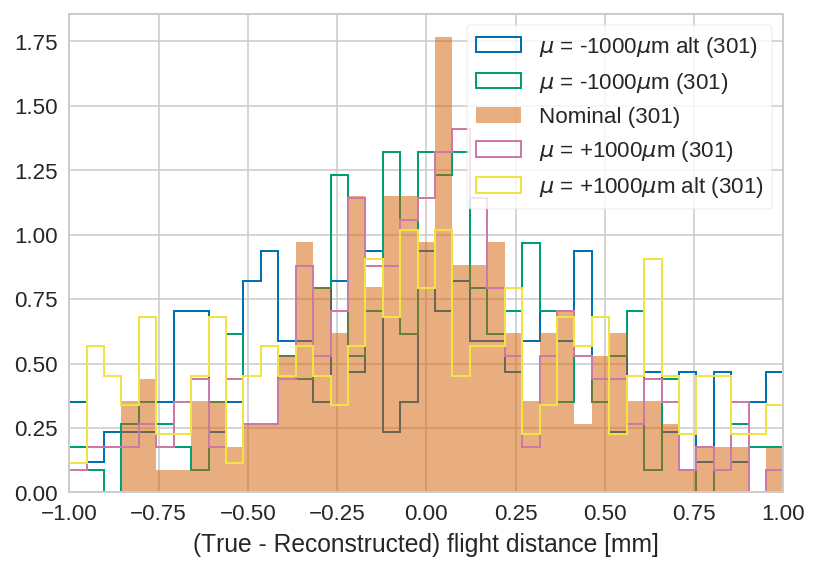

In [57]:
for scenario in scenarios:
    _particles = particles.query(f'(scenario == "{scenario}")')
    reco_fd = _particles.fd
    true_fd = _particles.true_fd
    res = true_fd - reco_fd
    print(scenario, sum(res > 1))
    print(f'  median = {res.median():.3f}')
    print(f'    0.5σ = {res.quantile(0.5+sigma[0.5]/2)-res.quantile(0.5-sigma[0.5]/2):.3f}')
    print(f'      1σ = {res.quantile(0.5+sigma[1]/2)-res.quantile(0.5-sigma[1]/2):.3f}')
    label = f'{utils.format_label(scenario)} ({len(res)})'
    if scenario == 'Nominal':
        res.hist(bins=np.linspace(-1, 1, 42), label=label, alpha=0.5, normed=True)
    else:
        res.hist(bins=np.linspace(-1, 1, 42), label=label, normed=True, histtype='step', lw=1)
plt.legend(loc='best', frameon=True)
plt.xlim((-1, 1))
plt.xlabel('(True - Reconstructed) flight distance [mm]')
pgf.savefig(join(out_dir, 'flight_distance_resolution.pgf.png'))

## D0 lifetime

Using reconstructed momentum of the $D^0$ in all cases.

$\gamma = \frac{1}{\sqrt{1+\frac{p}{m\left(D^0\right)}^2}}$

$t_{\text{proper}} = \frac{\text{FD}*\gamma}{c}$

In [58]:
particles.eval(f'proper_time = (fd/1000 * D0_gamma) /{utils.speed_of_light}', inplace=True)
particles.eval(f'true_proper_time = (true_fd/1000 * D0_true_gamma) /{utils.speed_of_light}', inplace=True)

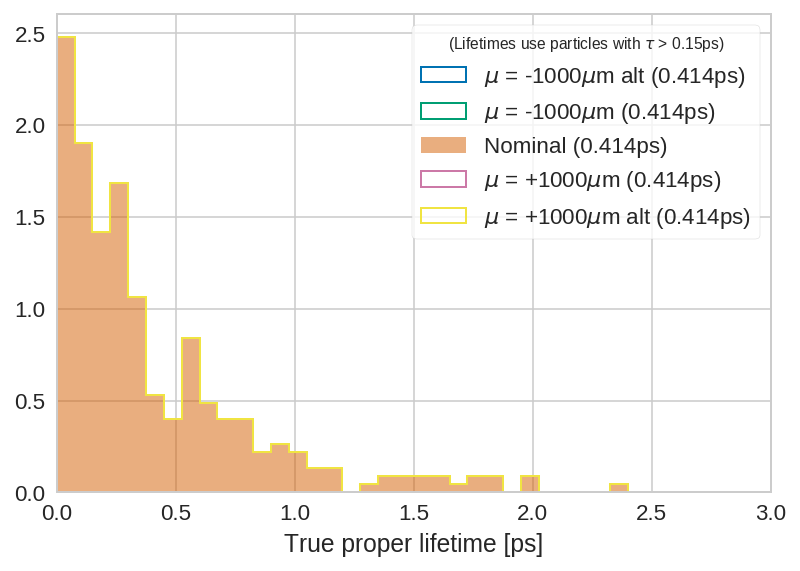

In [59]:
for scenario in scenarios:
    lt = particles.query(f'(scenario == "{scenario}")').true_proper_time*1e12
    lifetime = lt[lt > 0.15].quantile(1 - 1/np.exp(1)) - 0.15
    label = f'{utils.format_label(scenario)} ({lifetime:.3f}ps)'
    if scenario == 'Nominal':
        lt.hist(bins=np.linspace(0, 3e-0, 41), label=label, alpha=0.5, normed=True)
    else:
        lt.hist(bins=np.linspace(0, 3e-0, 41), label=label, normed=True, histtype='step', lw=1)
legend = plt.legend(loc='best', frameon=True, title='(Lifetimes use particles with $\\tau$ > 0.15ps)')
plt.setp(legend.get_title(), fontsize='xx-small')
plt.xlim((0, 3e-0))
plt.xlabel('True proper lifetime [ps]')
pgf.savefig(join(out_dir, 'true_proper_lifetime.pgf.png'))

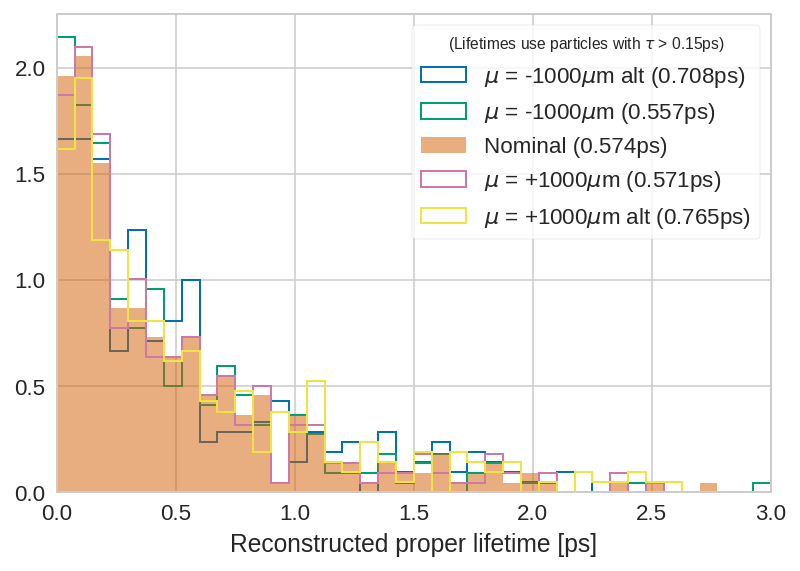

In [60]:
for scenario in scenarios:
    lt = particles.query(f'(scenario == "{scenario}")').proper_time*1e12
    lifetime = lt[lt > 0.15].quantile(1 - 1/np.exp(1)) - 0.15
    label = f'{utils.format_label(scenario)} ({lifetime:.3f}ps)'
    if scenario == 'Nominal':
        lt.hist(bins=np.linspace(0, 3e0, 41), label=label, alpha=0.5, normed=True)
    else:
        lt.hist(bins=np.linspace(0, 3e0, 41), label=label, normed=True, histtype='step', lw=1)
legend = plt.legend(loc='best', frameon=True, title='(Lifetimes use particles with $\\tau$ > 0.15ps)')
plt.setp(legend.get_title(), fontsize='xx-small')
plt.xlim((0, 3e0))
plt.xlabel('Reconstructed proper lifetime [ps]')
pgf.savefig(join(out_dir, 'reconstructed_proper_lifetime.pgf.png'))

                      scenario mean    median  0.5σ    1σ     
 tip_x=0um_y=-1000um_alternate -1.025  -0.036  0.182   0.702  
           tip_x=0um_y=-1000um -0.471  -0.015  0.091   0.201  
                       Nominal -0.475  -0.015  0.086   0.188  
           tip_x=0um_y=+1000um -0.469  -0.015  0.089   0.192  
 tip_x=0um_y=+1000um_alternate -0.883  -0.045  0.183   0.638  


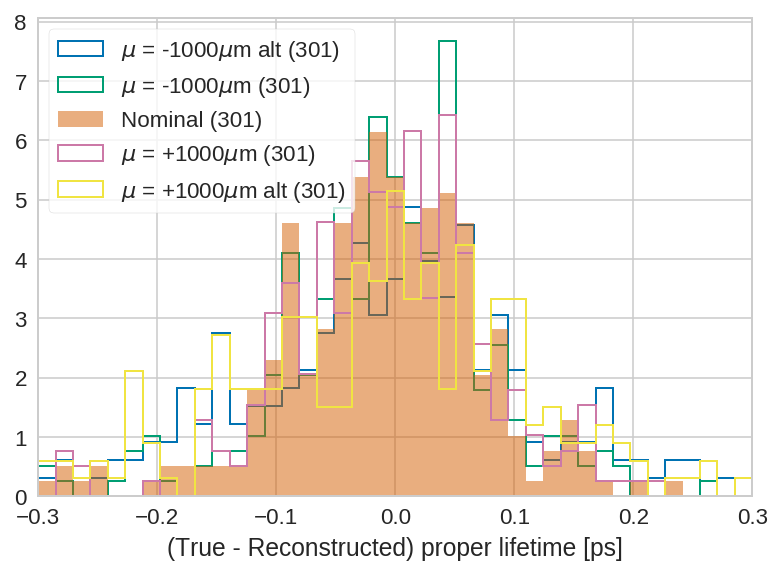

In [61]:
print(f'{"scenario".rjust(30)} {"mean".ljust(7)} {"median".ljust(7)} {"0.5σ".ljust(7)} {"1σ".ljust(7)}')
for scenario in scenarios:
    _particles = particles.query(f'(scenario == "{scenario}")')
    res = (_particles.true_proper_time - _particles.proper_time)*1e12
    print(scenario.rjust(30), end=' ')
    print(f'{res.mean():.3f}'.ljust(7), end=' ')
    print(f'{res.median():.3f}'.ljust(7), end=' ')
    print(f'{res.quantile(0.5+sigma[0.5]/2)-res.quantile(0.5-sigma[0.5]/2):.3f}'.ljust(7), end=' ')
    print(f'{res.quantile(0.5+sigma[1]/2)-res.quantile(0.5-sigma[1]/2):.3f}'.ljust(7))
    label = f'{utils.format_label(scenario)} ({len(res)})'
    if scenario == 'Nominal':
        res.hist(bins=np.linspace(-3e-1, 3e-1, 42), label=label, alpha=0.5, normed=True)
    else:
        res.hist(bins=np.linspace(-3e-1, 3e-1, 42), label=label, normed=True, histtype='step', lw=1)
plt.legend(loc='best', frameon=True)
plt.xlim((-3e-1, 3e-1))
plt.xlabel('(True - Reconstructed) proper lifetime [ps]')
pgf.savefig(join(out_dir, 'proper_lifetime_resolution.pgf.png'))

## Is the residual correllated with anything?

In [62]:
def process(y_var, dist_prop):
    def _(df):
        if len(df) > 10:
            res = df.eval(y_var)
            if callable(dist_prop):
                y = [dist_prop(res.sample(len(df), replace=True))
                     for i in range(1000)]
            else:
                y = [getattr(res.sample(len(df), replace=True), dist_prop)()
                     for i in range(1000)]
            return np.percentile(y, [50-34.1, 50, 50+34.1])
        else:
            return [0, 0, 0]
    
    return _

def plot_residual_vs(x_var, x_label, x_bins, y_var, y_label, foms=['median', 'mean', 'std'], pos_only=False):
    fig, axs = plt.subplots(1, len(foms), squeeze=False, figsize=(6*len(foms), 6))
    for ax, dist_prop in zip(axs.reshape(-1), foms):
        plt.sca(ax)
        grouped = particles.groupby(['scenario', pd.cut(particles.eval(x_var), x_bins)])
        grouped = grouped.apply(process(y_var, dist_prop))
        for scenario in grouped.index.levels[0]:
            x, y = zip(*grouped[scenario].items())
            x = [list(map(float, _x[1:-1].split(', '))) for _x in x]
            xs = np.array(list(map(np.mean, x)))
            low, mid, high = map(lambda x: np.array(x)*1e12, zip(*y))
            plt.errorbar(
                xs, mid,
                xerr=np.diff(x, axis=1)/2, yerr=(mid-low, high-mid),
                fmt=',', label=utils.format_label(scenario))

            # define our (line) fitting function
            fitfunc = lambda p, x: p[0] + p[1]*x
            errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

            avg_err = (high-mid + mid-low)/2 / mid
            (a, b), covar, *_ = optimize.leastsq(
                errfunc, [1.0, -1.0], args=(xs[mid != 0], mid[mid != 0], avg_err[mid != 0]))

            plt.plot(xs, a + b*xs, '--')

        plt.legend(loc='best', frameon=True)
        plt.ylabel(y_label)
        plt.xlabel(x_label)
        plt.xlim(x_bins[0], x_bins[-1])
        plt.title(f'{dist_prop} of redidual')
        lim = max(map(abs, ax.get_ylim()))
        ax.set_ylim([-lim, 0][pos_only or dist_prop == 'std'], lim)
    return x, y

### Lifetime residual vs slope

/pc2014-data3/cburr/.software/miniconda3/envs/analysis-3.6/lib/python3.6/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in true_divide


(0, 2.5)

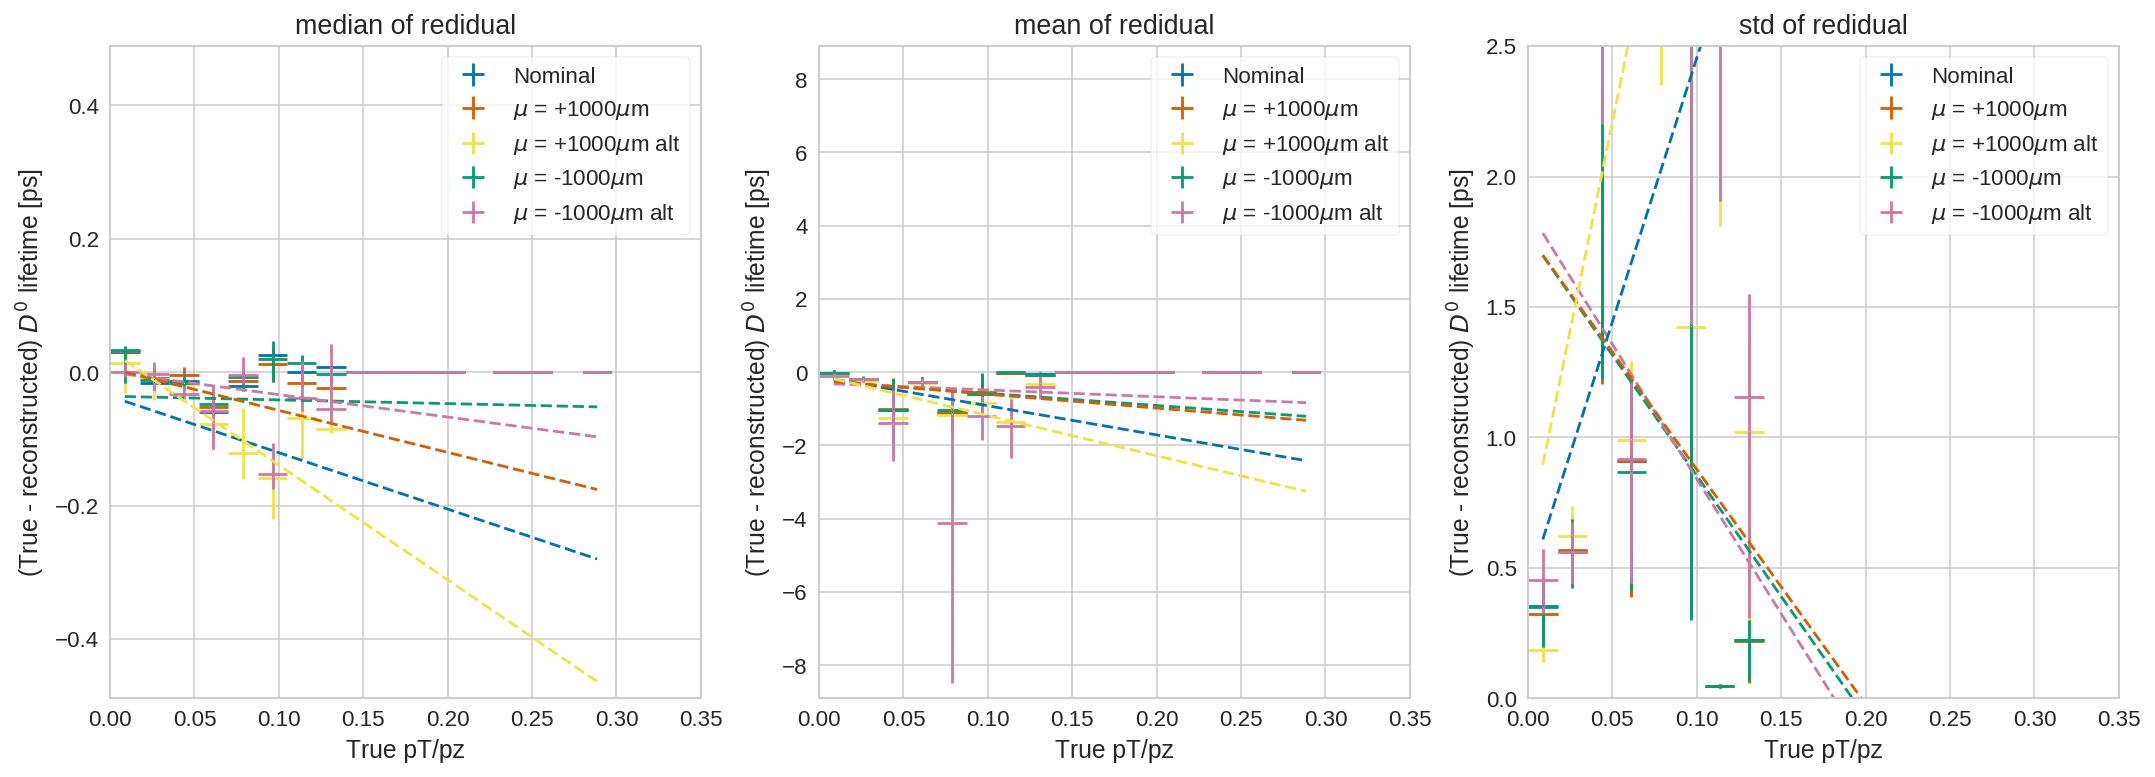

In [63]:
plot_residual_vs(
    'sqrt(D0_true_p_x**2+D0_true_p_y**2)/D0_true_p_z', 'True pT/pz', np.linspace(0, 0.35, 21),
    'true_proper_time - proper_time', '(True - reconstructed) $D^0$ lifetime [ps]'
)
pgf.savefig(join(out_dir, 'proper_lifetime_resolution_vs_slope.pgf.png'))
plt.ylim(0, 2.5)

### Lifetime resdidual vs true lifetime

/pc2014-data3/cburr/.software/miniconda3/envs/analysis-3.6/lib/python3.6/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in true_divide


(0, 2.5)

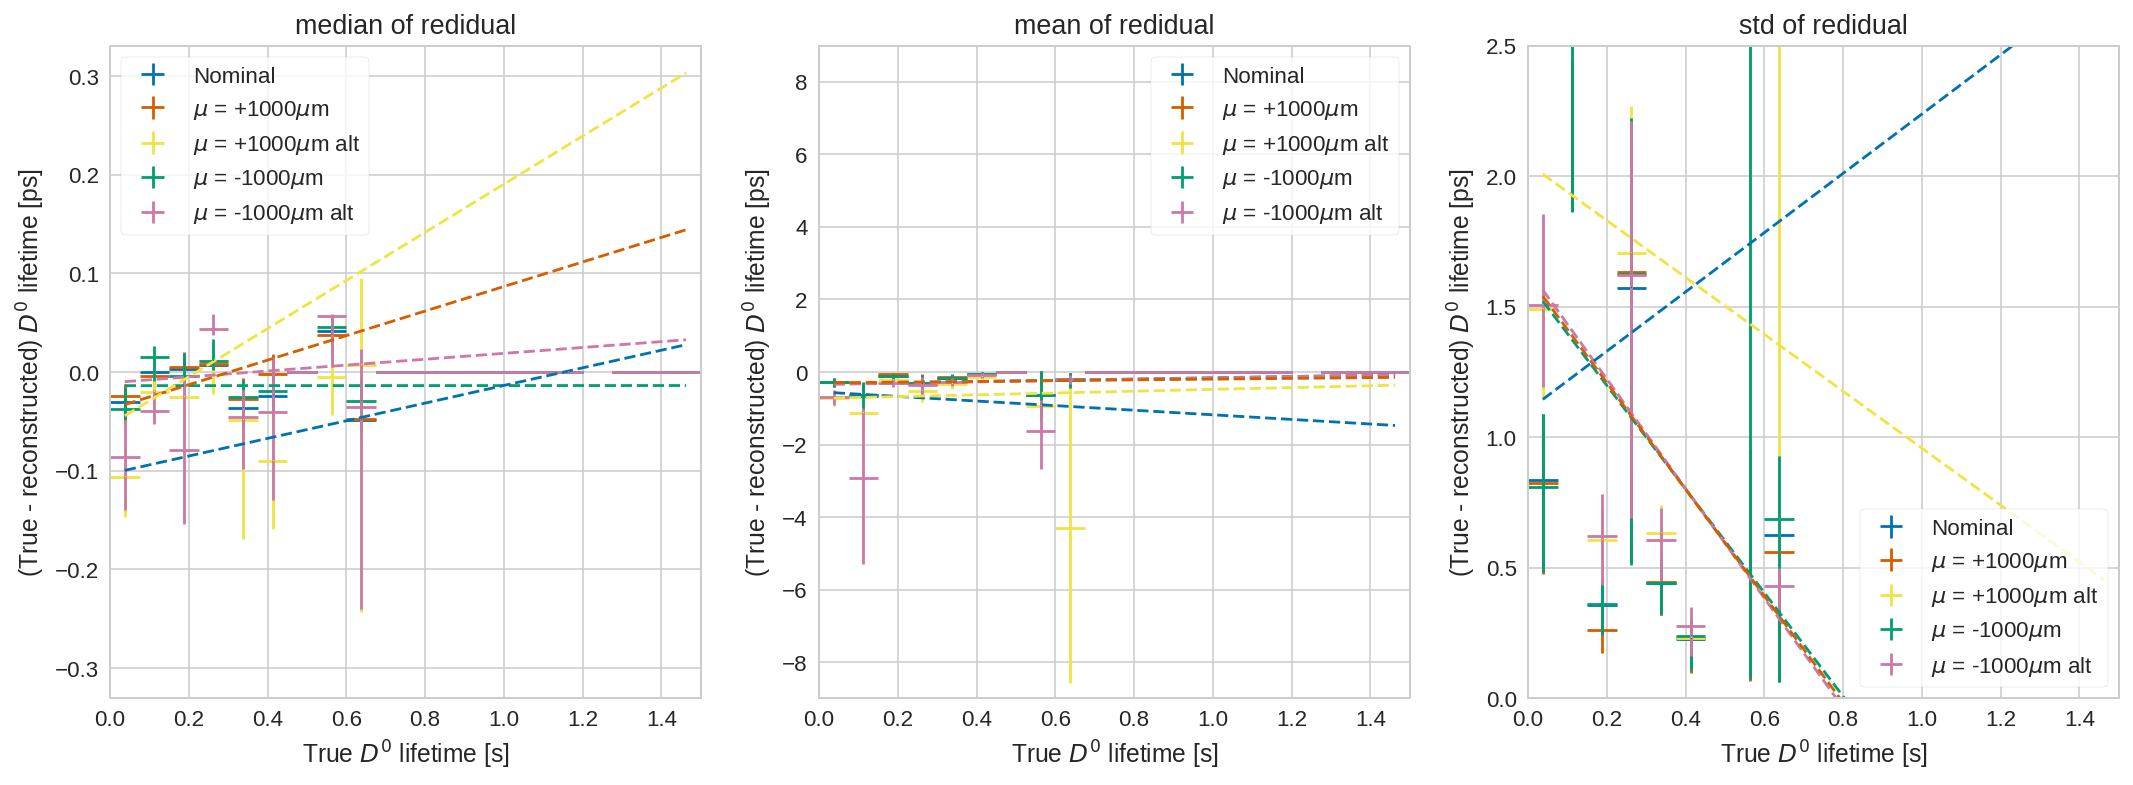

In [64]:
plot_residual_vs(
    'true_proper_time*1e12', 'True $D^0$ lifetime [s]', np.linspace(0, 1.5, 21),
    'true_proper_time - proper_time', '(True - reconstructed) $D^0$ lifetime [ps]'
)
pgf.savefig(join(out_dir, 'proper_lifetime_resolution_vs_true_lifetime.pgf.png'))
plt.ylim(0, 2.5)

### Lifetime resdidual vs true momentum

/pc2014-data3/cburr/.software/miniconda3/envs/analysis-3.6/lib/python3.6/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in true_divide


(0, 2.5)

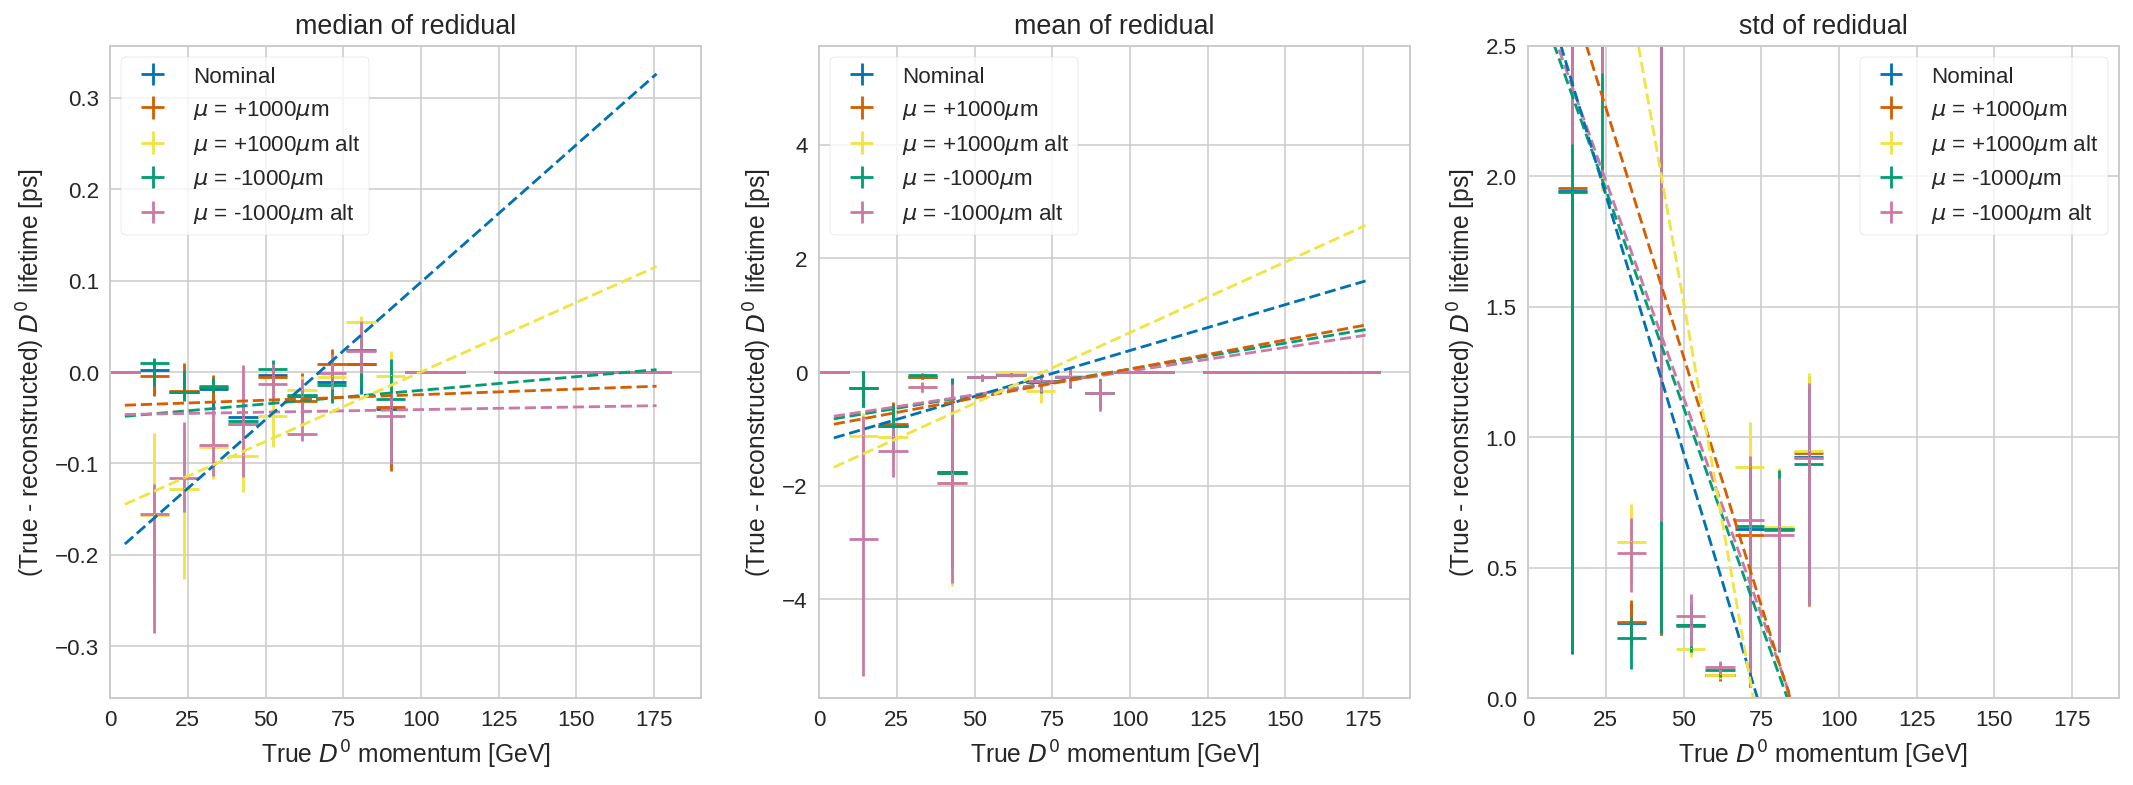

In [65]:
plot_residual_vs(
    'D0_true_p/1000', 'True $D^0$ momentum [GeV]', np.linspace(0, 1.9e2, 21),
    'true_proper_time - proper_time', '(True - reconstructed) $D^0$ lifetime [ps]'
)
pgf.savefig(join(out_dir, 'proper_lifetime_resolution_vs_true_momentum.pgf.png'))
plt.ylim(0, 2.5)

In [66]:
def calc_lt(s):
    return s[s > 0.15e-12].quantile(1 - 1/np.exp(1)) - 0.15e-12

/pc2014-data3/cburr/.software/miniconda3/envs/analysis-3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)
/pc2014-data3/cburr/.software/miniconda3/envs/analysis-3.6/lib/python3.6/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in true_divide


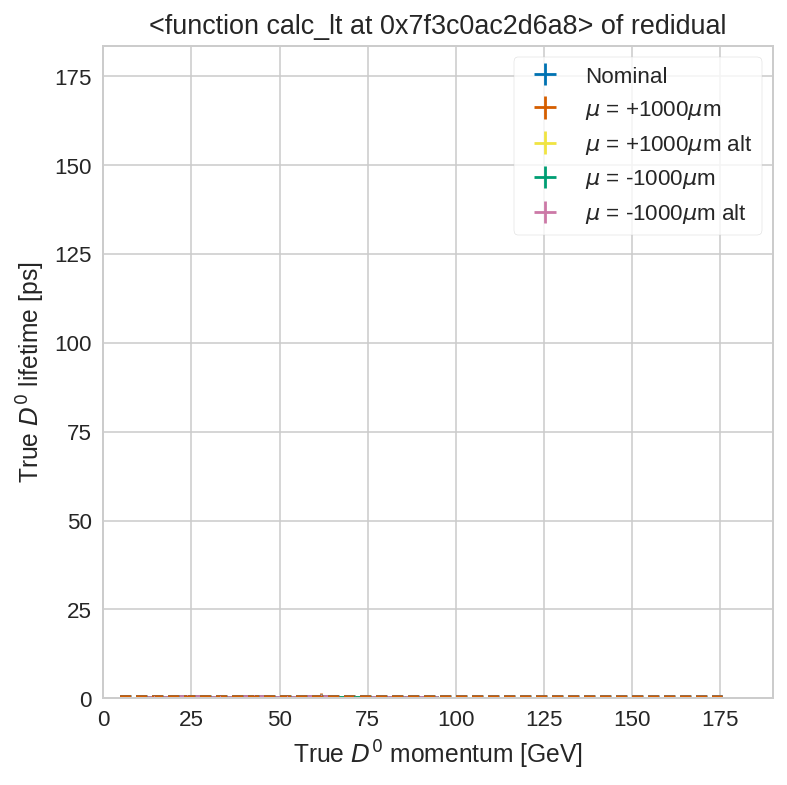

In [67]:
plot_residual_vs(
    'D0_true_p/1000', 'True $D^0$ momentum [GeV]', np.linspace(0, 1.9e2, 21),
    'true_proper_time', 'True $D^0$ lifetime [ps]', foms=[calc_lt], pos_only=True
)
pgf.savefig(join(out_dir, 'true_proper_lifetime_vs_true_momentum.pgf.png'))

/pc2014-data3/cburr/.software/miniconda3/envs/analysis-3.6/lib/python3.6/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in true_divide


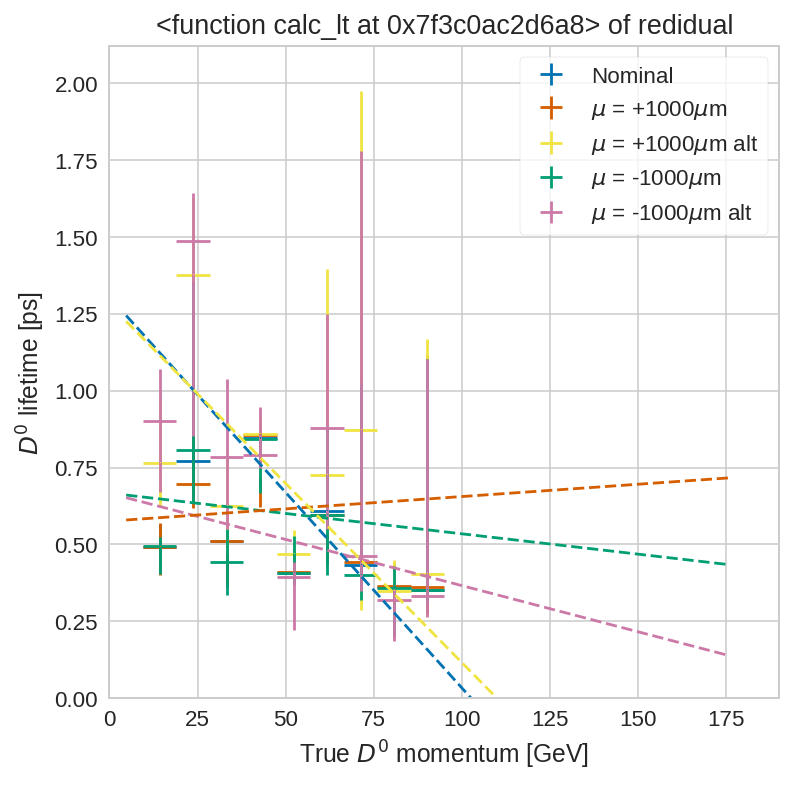

In [68]:
x, y = plot_residual_vs(
    'D0_true_p/1000', 'True $D^0$ momentum [GeV]', np.linspace(0, 1.9e2, 21),
    'proper_time', '$D^0$ lifetime [ps]', foms=[calc_lt], pos_only=True
)
pgf.savefig(join(out_dir, 'proper_lifetime_vs_momentum.pgf.png'))